<a href="https://colab.research.google.com/github/Faskill/MLOps-Article-Classification/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
# Extracting projects
PROJECTS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
projects = pd.read_csv(PROJECTS_URL)
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [2]:
# Extracting tags
TAGS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
tags = pd.read_csv(TAGS_URL)
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [3]:
df = pd.merge(projects, tags, on="id", how = "outer")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [4]:
df = df[df.tag.notnull()]

df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [5]:
# Saving data locally
df.to_csv("labeled_projects.csv", index=False)

In [6]:
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
mlops                           79
reinforcement-learning          56
graph-learning                  45
time-series                     31
Name: tag, dtype: int64

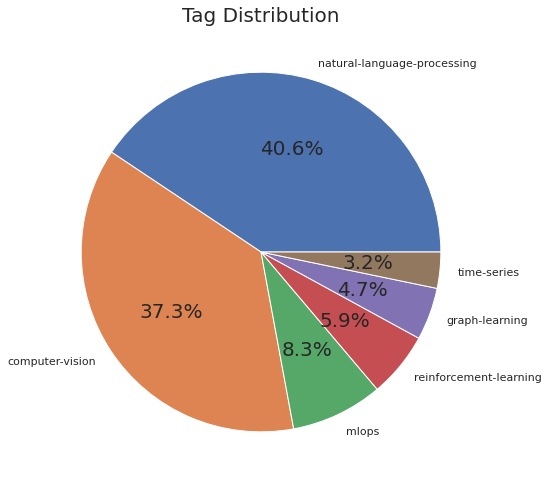

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

vc = df.tag.value_counts()
plt.pie(vc, labels = vc.index,autopct='%1.1f%%')
plt.title('Tag Distribution')
plt.show()

In [8]:
df['title_length'] = df['title'].apply(len)
df['desc_length'] = df['description'].apply(len)

df.head()

,id,created_on,title,description,tag,title_length,desc_length
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89


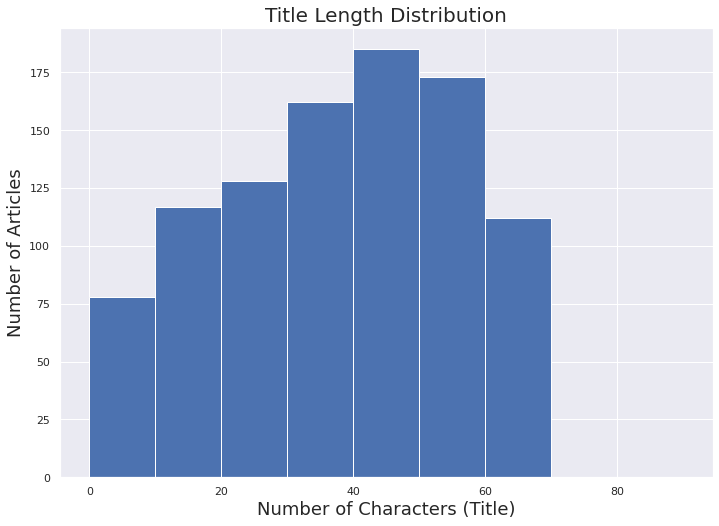

In [9]:
plt.hist(df['title_length'], bins = range(0,100,10))
plt.title('Title Length Distribution')
plt.xlabel('Number of Characters (Title)')
plt.ylabel('Number of Articles')
plt.show()

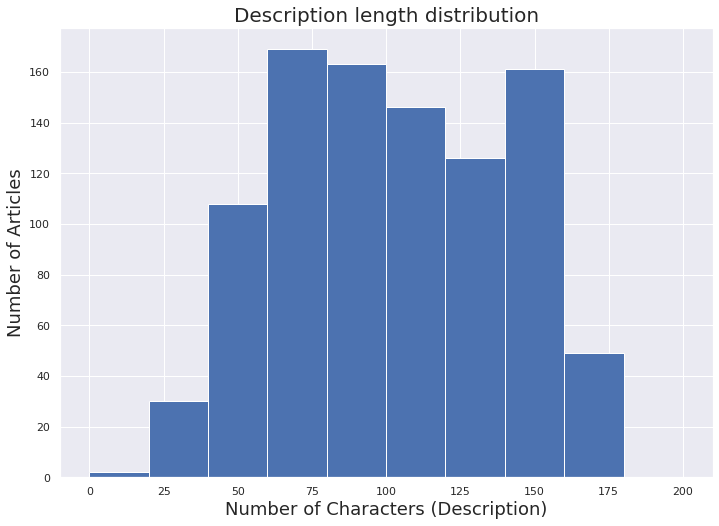

In [10]:
plt.hist(df['desc_length'], bins = range(0,220,20))
plt.title('Description length distribution')
plt.xlabel('Number of Characters (Description)')
plt.ylabel('Number of Articles')
plt.show()

In [11]:
#Let's investigate the outliers with a description below 25 characters
df[df.desc_length < 25]

,id,created_on,title,description,tag,title_length,desc_length
29,108,2020-03-21 23:17:38,Tuned ALBERT (ensemble model),Top 6 in Squad 2.0,natural-language-processing,29,18
341,880,2020-05-16 11:50:31,How Deep Is Your Love For Transfer Learning In...,A review of NLP research,natural-language-processing,51,24
536,1480,2020-06-16 23:06:13,A Guide to Natural Language Processing With Al...,basics of using AllenNLP,natural-language-processing,52,24
695,1856,2020-07-14 03:21:00,DeepDream Video Style Transfer,DeepDream on Video,computer-vision,30,18
737,1934,2020-07-21 01:47:01,Graphein,Protein Graph Library,graph-learning,8,21
747,1954,2020-07-24 06:43:59,Azure ML,MLOps using Azure ML.,mlops,8,21
942,2417,2020-10-02 09:44:25,Parallelizing Prophet Cross-Validation with Dask,Applied Example w/ Code,time-series,48,23


In [12]:
df['tag'].unique()

array(['computer-vision', 'graph-learning', 'reinforcement-learning',
       'natural-language-processing', 'mlops', 'time-series'],
      dtype=object)

In [13]:
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets

# Most frequent tokens for each tag
@widgets.interact(tag=df['tag'].unique())
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    plt.show()

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

In [17]:
#Feature engineering

df['text'] = df['title'] + ' ' + df['description']

df.head()

,id,created_on,title,description,tag,title_length,desc_length,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89,Diffusion to Vector Reference implementation o...


In [18]:
!pip install nltk==3.7 -q
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [19]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:

def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower:
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [24]:
# Apply to dataframe
df['cleaned_text'] = df.text.apply(clean_text, lower=True, stem=False)
print (f"{df.text.values[0]}\n{df.cleaned_text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [25]:
import json
#List of accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

#Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [27]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [29]:

# Replace this tag with "other"
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [31]:
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                           87
mlops                           79
graph-learning                  45
Name: tag, dtype: int64

In [83]:
#Not enough data to identify the graph learning topics (we set a threshold at 75)
#We will join this category with our "other" category
def filter_tags(tag, exclude=[]):
  if tag in exclude:
    tag = None
  return tag

df.tag = df.tag.apply(filter_tags, exclude = ['graph-learning'])

df.tag = df.tag.fillna("other")
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                          132
mlops                           79
Name: tag, dtype: int64

In [84]:
import numpy as np
import random


# Get data
X = df.cleaned_text.to_numpy()
y = df.tag

In [85]:
#Defining custom LabelEncoder (alternative would be to use sklearn's implementation)

class LabelEncoder(object):
    """Encode labels into unique indices"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [86]:

# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

num_classes

4

In [87]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [88]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [89]:
#Testing encoder

# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [90]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))

['computer-vision', 'mlops', 'mlops']

In [91]:

# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [92]:
from sklearn.model_selection import train_test_split

# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [93]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [94]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)


print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [95]:
# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}


# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [96]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))
    
    
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,247,56,270,93
test,252,56,270,93


We can see that our test/train split are quite balanced.
Let's calculate the standard deviation :

In [97]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.9851056877051131

In [100]:
#Example of code for multi-label classification
!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,efficientdet pytorch pytorch implementation ef...,computer-vision
1,stackover flow data analysis analysing certain...,natural-language-processing
2,nethack learning environment nle procedurally ...,other
3,text preprocessing python using spacy library ...,natural-language-processing
4,nlp viewer simple website browsing popular nlp...,natural-language-processing


In [102]:
#Data Augmentation :

!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.8 -q

import nlpaug.augmenter.word as naw

In [103]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")
text = "Conditional image generation using Variational Autoencoders and GANs."

In [104]:
# Substitutions
substitution.augment(text)

'automated collision matching using variational autoencoders implement gans.'

Substitutions do not seem like a very good idea because they remove keywords like GAN here.


In [105]:
# Insertions
insertion.augment(text)

'conditional image generation experiments using dynamic variational matrix autoencoders and binary gans.'

The problem is now that there is a risk that keywords will get inserted into our text samples.

In [106]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [107]:
flattened_aliases

{'computer vision': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'mlops': ['production'],
 'production': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing']}

In [108]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [109]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [110]:
#Using the inflect package to add plurals to our aliases

!pip install inflect
import inflect

p = inflect.engine()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
inflected_aliases = {}

for _tag, _alias in flattened_aliases.items():
    inflected_aliases[_tag] = _alias
    inflected_aliases[p.plural(_tag)] = _alias

inflected_aliases

{'computer vision': ['cv', 'vision'],
 'computer visions': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'cvs': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'visions': ['cv', 'computer vision'],
 'mlops': ['production'],
 'mlop': ['production'],
 'production': ['mlops'],
 'productions': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'natural language processings': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlps': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing'],
 'nlprocs': ['nlp', 'natural language processing']}

In [112]:
#Using snorkel's transformations to apply this modification to our data

from snorkel.augmentation import transformation_function

@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases."""
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(inflected_aliases[tag])}{x.text[match.end():]}"
    return x

In [113]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey reinforcement learning nlproc tasks
survey reinforcement learning natural language processing tasks


In [114]:

# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate cv apply jobs using natural language processing
autogenerate computer vision apply jobs using nlp
autogenerate cv apply jobs using nlproc


In [115]:
# Defining an Augmentation Policy
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier


# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:02<00:00, 226.72it/s]


,text,tag
0,efficientdet pytorch pytorch implementation ef...,computer-vision
1,stackover flow data analysis analysing certain...,natural-language-processing
2,nethack learning environment nle procedurally ...,other
3,text preprocessing python using spacy library ...,natural-language-processing
4,nlp viewer simple website browsing popular nlp...,natural-language-processing


In [116]:
len(train_df), len(train_df_augmented)

(668, 929)

In [117]:
#This was an example of Data augmentation, but we will not use this in the rest of the project